In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import importlib
import os
from tqdm.notebook import tqdm
from collections import OrderedDict
import re
%matplotlib notebook
import json
import sys
# import imp
import random
import copy
import gc
import tables

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0')
print(torch.cuda.get_device_name(torch.device('cuda:0')))

NVIDIA GeForce RTX 3090


# Load DR4 run 01

The 14th shot is bad

In [4]:
npz_file = np.load('../data_aux/DR4_01_isat.npz')

In [5]:
isat_p22 = npz_file['isat_p22']
isat_p29 = npz_file['isat_p29']
isat_p34 = npz_file['isat_p34']
pos_x_p22 = npz_file['pos_x_p22']
pos_x_p29 = npz_file['pos_x_p29']
pos_x_p34 = npz_file['pos_x_p34']
pos_z = npz_file['pos_z']
timebase = npz_file['timebase']

In [6]:
dt = (timebase[-1] - timebase[0]) / 250000

In [7]:
20e-3/dt

100000.40084284286

In [8]:
30e-3/dt

150000.6012642643

In [9]:
timebase[0]

-0.010000136

<IPython.core.display.Javascript object>


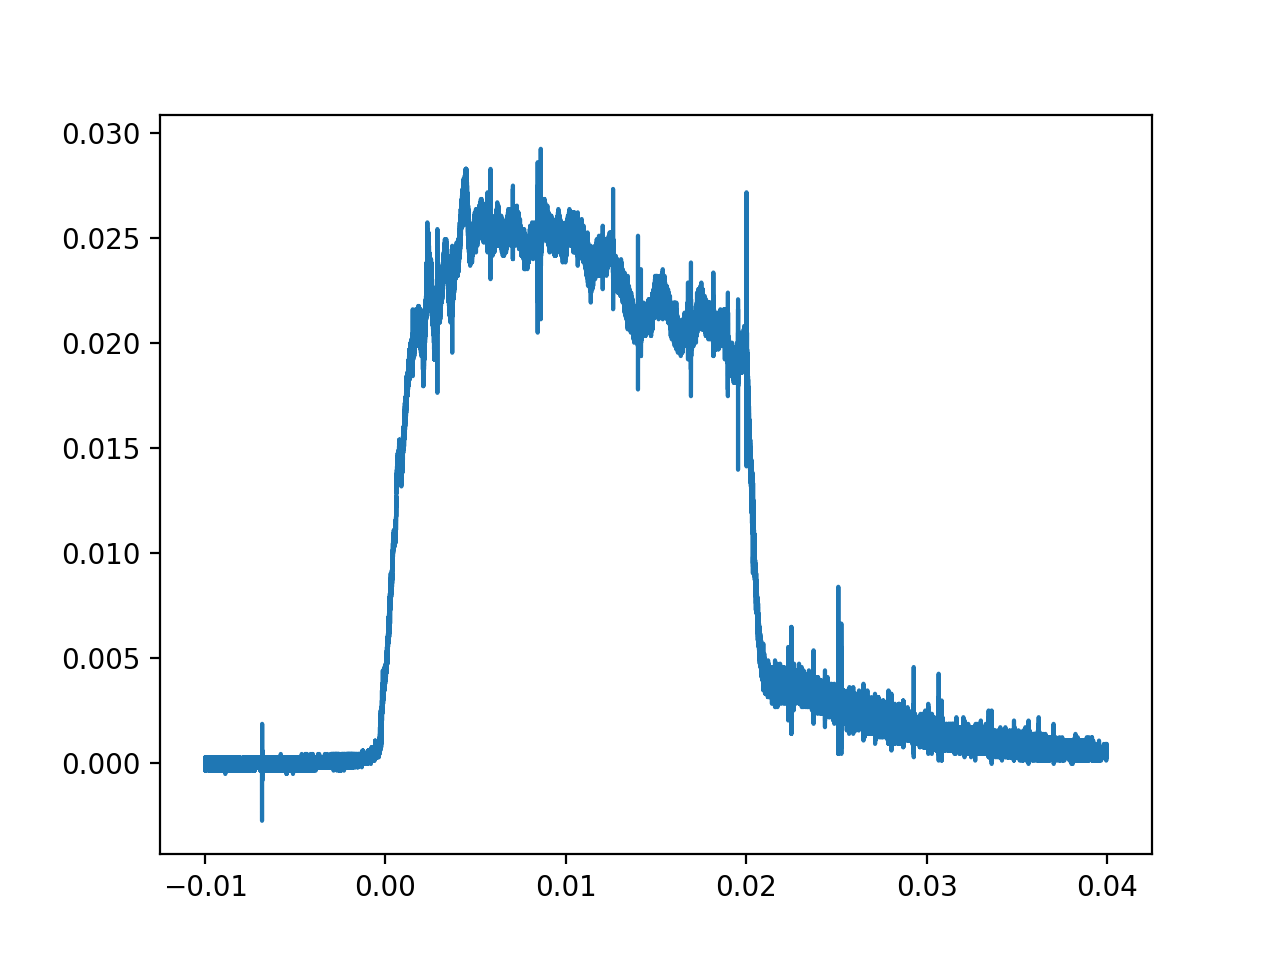

In [10]:
plt.figure()
plt.plot(timebase, isat_p22[10, 0, :])

# Load model

In [11]:
ens_name = 'beta-NLL_wd-0.0'

In [12]:
os.chdir('/home/phil/Desktop/profile-predict/PP1/training_runs/')

In [13]:
runs = sorted(os.listdir(ens_name))
if 'plots' in runs:
    runs.remove('plots')

In [14]:
runs

['2024-09-11_16h-34m-43s',
 '2024-09-11_17h-06m-22s',
 '2024-09-11_17h-37m-46s',
 '2024-09-11_18h-09m-16s',
 '2024-09-11_18h-40m-47s']

In [15]:
model_paths = [ens_name + "/" + run for run in runs]

model_versions = ["checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738"]

In [16]:
models = []
for model_path, model_version in zip(model_paths, model_versions):
    print("Loading model " + model_path + " version " + model_version)
    os.chdir("/home/phil/Desktop/profile-predict/PP1/training_runs/" + model_path + "/")

    spec = importlib.util.spec_from_file_location("train_dense_beta_NLL_copy", "train_dense_beta_NLL_copy.py")
    loaded_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(loaded_module)
    with open("hyperparams.json") as json_f:
        hyperparams = json.loads(json_f.read())

    # imp.reload(ebm)
    model = loaded_module.ModelClass(hyperparams).to(device)
    # ckpt = torch.load("experiments_modular/" + model_path + "/" + model_version + ".pt")
    ckpt = torch.load(model_version + ".pt")

    model_dict = OrderedDict()
    pattern = re.compile('module.')
    state_dict = ckpt['model_state_dict']
    for k,v in state_dict.items():
        if re.search("module", k):
            model_dict[re.sub(pattern, '', k)] = v
        else:
            model_dict = state_dict
    model.load_state_dict(model_dict, strict=True)

    data_train_path = "/home/phil/Desktop/profile-predict/datasets/" + hyperparams['dataset']

    print("Number of parameters: {}".format(np.sum([p.numel() for p in model.parameters() if p.requires_grad])))
    
    models.append(model)
# for model in models:
#     model = model.cpu()

Loading model beta-NLL_wd-0.0/2024-09-11_16h-34m-43s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_17h-06m-22s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_17h-37m-46s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_18h-09m-16s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_18h-40m-47s version checkpoints/model-499-738
Number of parameters: 201218


/home/phil/anaconda3/envs/gr-id-pinn-2/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [17]:
data_train_path = "/home/phil/Desktop/profile-predict/datasets/DR_combo_PP1_isat_04_train_cv-0.npz"

In [18]:
train_npz = np.load(data_train_path)
x_mean = train_npz['x_mean']
x_ptp = train_npz['x_ptp']
y_mean = train_npz['y_mean']
y_ptp = train_npz['y_ptp']

In [19]:
RMSE = 0.054 * y_ptp

In [20]:
os.chdir('/home/phil/Desktop/profile-predict/PP1/')
# os.makedirs('plots/' + model_version[12:], exist_ok=True)
# os.makedirs('plots/', exist_ok=True)

# Compare DR4_01

In [167]:
x_offset = np.array([8.28375594, 12.43209571, 8.50826234]) - 10 / np.sqrt(2)
y_offset = np.array([-8.01434826, -7.41275231, -9.74304756]) + 10 / np.sqrt(2)

In [168]:
x_coords_01 = np.array([np.mean(pos_x_p22, axis=1), np.mean(pos_x_p29, axis=1), np.mean(pos_x_p34, axis=1)]) / np.sqrt(2) + x_offset[:, np.newaxis]
y_coords_01 = -np.array([np.mean(pos_x_p22, axis=1), np.mean(pos_x_p29, axis=1), np.mean(pos_x_p34, axis=1)]) / np.sqrt(2) + y_offset[:, np.newaxis]

In [169]:
inputs = np.zeros((41*3, 12), dtype=np.float32)
inputs[:, 0] = 822  # interpolating
inputs[:, 1] = 500
inputs[:, 2] = 1500
inputs[:, 3] = 90  # GAS PUFF VOLTAGE
inputs[:, 4] = 160  # 160 V discharge voltage -- out of bounds of model
inputs[:, 5] = 38
inputs[:, 6] = np.concatenate(x_coords_01)
inputs[:, 7] = np.concatenate(y_coords_01)
inputs[:, 8] = np.repeat(pos_z, 41)
inputs[:, 9] = 0
inputs[:, 10] = 1
inputs[:, 11] = 0
model_inputs = (inputs - x_mean) / x_ptp

In [170]:
model_predictions = []
for model in models:
    model_predictions.append(model(torch.tensor(model_inputs, dtype=torch.float32, device='cuda')).cpu().detach().numpy().astype(np.float64))
    model = None
    torch.cuda.empty_cache()
predictions = np.array(model_predictions)

In [171]:
predictions.shape

(5, 123, 2)

In [172]:
pos_z

array([990.45, 766.8 , 607.05])

In [173]:
pred_mean = np.mean(predictions[:, :, 0], axis=0)
pred_var = (np.mean(predictions[:, :, 1] + predictions[:, :, 0] ** 2, axis=0) - pred_mean ** 2) * y_ptp ** 2
pred_aleatoric = (np.mean(predictions[:, :, 1], axis=0)) * y_ptp ** 2
pred_epistemic = (np.mean(predictions[:, :, 0] ** 2, axis=0) - pred_mean ** 2)  * y_ptp ** 2
pred_mean = pred_mean * y_ptp + y_mean

<IPython.core.display.Javascript object>


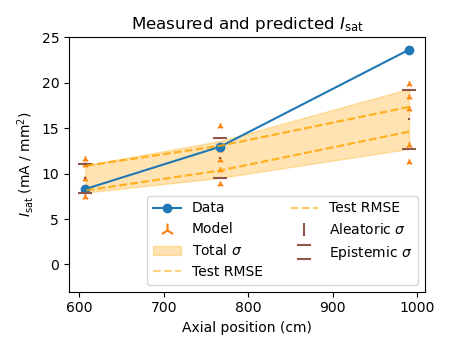

In [175]:
plt.figure(figsize=(4.5, 3.5))

pidx = 12

plt.title(r'Measured and predicted $I_\mathrm{sat}$')
plt.xlabel('Axial position (cm)')
plt.ylabel(r'$I_\mathrm{sat}$ (mA / mm$^2$)')
plt.plot(pos_z, np.array([np.mean(isat_p22[pidx, :, 100000:150000]), np.mean(isat_p29[pidx, :, 100000:150000]), np.mean(isat_p34[pidx, :, 100000:150000])]) * 1e3,
         marker='o', color='tab:blue', label='Data')

# Plot model predictions
for i in range(len(models)):
    plt.scatter(pos_z, (predictions[i, pidx::41, 0] * y_ptp + y_mean) * 1e3, color='tab:orange', marker='2', s=20)
plt.scatter([], [], color='tab:orange', marker='2', label='Model', s=100)


plt.errorbar(pos_z, pred_mean[pidx::41] * 1e3, yerr=np.sqrt(pred_aleatoric[pidx::41]) * 1e3, lw=0, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:brown', label=r'Aleatoric $\sigma$')
plt.errorbar(pos_z, pred_mean[pidx::41] * 1e3, yerr=np.sqrt(pred_epistemic[pidx::41]) * 1e3, lw=0, elinewidth=0, capsize=5, capthick=1.5, color='tab:brown', label=r'Epistemic $\sigma$')
plt.fill_between(pos_z, (pred_mean[10::41] + np.sqrt(pred_var[pidx::41])) * 1e3,
                 (pred_mean[pidx::41] - np.sqrt(pred_var[pidx::41])) * 1e3, alpha=0.3, color='orange', label=r'Total $\sigma$')
plt.plot(pos_z, (pred_mean[pidx::41] + RMSE) * 1e3, alpha=0.5, color='orange', linestyle='dashed', label='Test RMSE')
plt.plot(pos_z, (pred_mean[pidx::41] - RMSE) * 1e3, alpha=0.5, color='orange', linestyle='dashed')

plt.plot(pos_z, (pred_mean[pidx::41] + RMSE) * 1e3, alpha=0.6, color='orange', label='Test RMSE', linestyle='dashed')
plt.plot(pos_z, (pred_mean[pidx::41] - RMSE) * 1e3, alpha=0.6, color='orange', linestyle='dashed')

plt.legend(ncols=2, loc='lower right')
plt.ylim(-3, 0.025 * 1e3)
plt.tight_layout()
# plt.savefig('plots/inference/measured-vs-predicted_160V.pdf')

# Compare DR4_02

## Using radial coordinate

In [54]:
pos_z

array([990.45, 766.8 , 607.05])

In [30]:
isat_02_p22 = 0.009209912
isat_02_p29 = 0.0035189053
isat_02_p34 = 0.0027339235

In [61]:
inputs_02 = np.zeros((5, 12), dtype=np.float32)
inputs_02[:, 0] = 1250
inputs_02[:, 1] = 500
inputs_02[:, 2] = 1500
inputs_02[:, 3] = 90
inputs_02[:, 4] = 90
inputs_02[:, 5] = 38
inputs_02[:, 6] = np.array([13, 11.5, 14.5, 12.9, 13])
inputs_02[:, 7] = 0


inputs_02[:, 8] = np.array([pos_z[0], 890, pos_z[1], 690, pos_z[2]])
inputs_02[:, 9] = 0
inputs_02[:, 10] = 1
inputs_02[:, 11] = 0
model_inputs_02 = (inputs_02 - x_mean) / x_ptp

In [62]:
model_predictions_02 = []
for model in models:
    model_predictions_02.append(model(torch.tensor(model_inputs_02, dtype=torch.float32, device='cuda')).cpu().detach().numpy().astype(np.float64))
    model = None
    torch.cuda.empty_cache()
predictions_02 = np.array(model_predictions_02)

In [63]:
pred_mean_02 = np.mean(predictions_02[:, :, 0], axis=0)
pred_var_02 = (np.mean(predictions_02[:, :, 1] + predictions_02[:, :, 0] ** 2, axis=0) - pred_mean_02 ** 2) * y_ptp ** 2
pred_aleatoric_02 = np.mean(predictions_02[:, :, 1], axis=0) * y_ptp ** 2
pred_epistemic_02 = (np.mean(predictions_02[:, :, 0] ** 2, axis=0) - pred_mean_02 ** 2) * y_ptp ** 2
pred_mean_02 = pred_mean_02 * y_ptp + y_mean

<IPython.core.display.Javascript object>


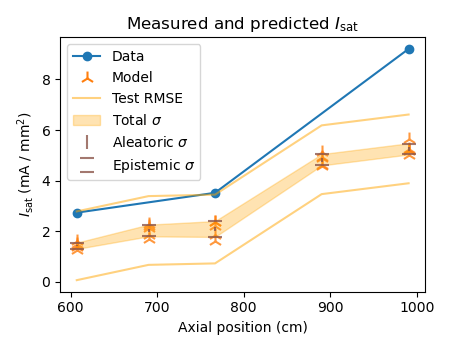

In [64]:
plt.figure(figsize=(4.5, 3.5))

plt.title(r'Measured and predicted $I_\mathrm{sat}$')
plt.xlabel('Axial position (cm)')
plt.ylabel(r'$I_\mathrm{sat}$ (mA / mm$^2$)')

# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.plot(pos_z, [isat_02_p22 * 1e3, isat_02_p29 * 1e3, isat_02_p34 * 1e3], marker='o', color='tab:blue', label='Data')
# Plot model predictions
for i in range(len(models)):
    plt.scatter(inputs_02[:, 8], (predictions_02[i, :, 0] * y_ptp + y_mean) * 1e3, color='tab:orange', marker='2', s=100, alpha=0.8)
plt.scatter([], [], color='tab:orange', marker='2', label='Model', s=100)

plt.plot(inputs_02[:, 8], (pred_mean_02 + RMSE) * 1e3, alpha=0.5, color='orange', label='Test RMSE')
plt.plot(inputs_02[:, 8], (pred_mean_02 - RMSE) * 1e3, alpha=0.5, color='orange')

plt.fill_between(inputs_02[:, 8], (pred_mean_02 + np.sqrt(pred_var_02)) * 1e3,
                 (pred_mean_02 - np.sqrt(pred_var_02)) * 1e3, alpha=0.3, color='orange', label=r'Total $\sigma$')

plt.errorbar(inputs_02[:, 8], pred_mean_02 * 1e3, yerr=(np.sqrt(pred_aleatoric_02)) * 1e3, lw=0, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:brown', alpha=0.8, label=r'Aleatoric $\sigma$')
plt.errorbar(inputs_02[:, 8], pred_mean_02 * 1e3, yerr=(np.sqrt(pred_epistemic_02)) * 1e3, lw=0, elinewidth=0, capsize=5, capthick=1.5, color='tab:brown', alpha=0.8, label=r'Epistemic $\sigma$')

plt.legend()
plt.tight_layout()
# plt.savefig('plots/inference/worst_axial_var-validation.pdf')

## using xy

In [59]:
pos_z

array([990.45, 766.8 , 607.05])

In [60]:
mean_x_03 = 9.741371
mean_y_03 = -8.390049

In [65]:
inputs_03 = np.zeros((5, 12), dtype=np.float32)
inputs_03[:, 0] = 1250
inputs_03[:, 1] = 500
inputs_03[:, 2] = 1500
inputs_03[:, 3] = 90
inputs_03[:, 4] = 90
inputs_03[:, 5] = 38
# inputs_03[:, 6] = np.array([0, 0, 0, 0, 0])
# inputs_03[:, 6] = np.array([10, 10, 10, 10, 10])
inputs_03[:, 6] = np.array([8.28375594, mean_x_03, 12.43209571, mean_x_03, 8.50826234])
inputs_03[:, 7] = np.array([-8.01434826, mean_y_03, -7.41275231, mean_y_03, -9.74304756])
# inputs_03[:, 8] = pos_z
inputs_03[:, 8] = np.array([pos_z[0], 890, pos_z[1], 690, pos_z[2]])
inputs_03[:, 9] = 0
# inputs_03[:, 9] = -0.785
inputs_03[:, 10] = 1
inputs_03[:, 11] = 0
model_inputs_03 = (inputs_03 - x_mean) / x_ptp

In [66]:
np.mean(inputs_03[:, 6])

9.741371

In [67]:
np.mean(inputs_03[:, 7])

-8.39005

In [68]:
model_predictions_03 = []
for model in models:
    model_predictions_03.append(model(torch.tensor(model_inputs_03, dtype=torch.float32, device='cuda')).cpu().detach().numpy().astype(np.float64))
    model = None
    torch.cuda.empty_cache()
predictions_03 = np.array(model_predictions_03)

In [69]:
pred_mean_03 = np.mean(predictions_03[:, :, 0], axis=0)
pred_var_03 = (np.mean(predictions_03[:, :, 1] + predictions_03[:, :, 0] ** 2, axis=0) - pred_mean_03 ** 2) * y_ptp ** 2
pred_aleatoric_03 = np.mean(predictions_03[:, :, 1], axis=0) * y_ptp ** 2
pred_epistemic_03 = (np.mean(predictions_03[:, :, 0] ** 2, axis=0) - pred_mean_03 ** 2) * y_ptp ** 2
pred_mean_03 = pred_mean_03 * y_ptp + y_mean

<IPython.core.display.Javascript object>


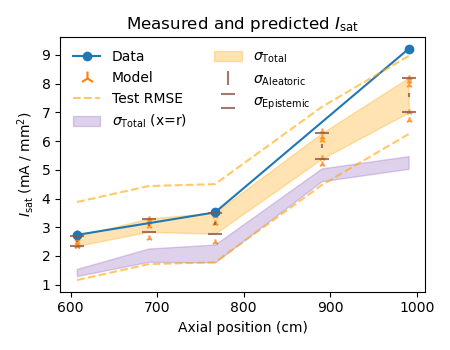

In [70]:
plt.figure(figsize=(4.5, 3.5))

plt.title(r'Measured and predicted $I_\mathrm{sat}$')
plt.xlabel('Axial position (cm)')
plt.ylabel(r'$I_\mathrm{sat}$ (mA / mm$^2$)')

# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.plot(pos_z, [isat_02_p22 * 1e3, isat_02_p29 * 1e3, isat_02_p34 * 1e3], marker='o', color='tab:blue', label='Data')
# Plot model predictions
for i in range(len(models)):
    plt.scatter(inputs_03[:, 8], (predictions_03[i, :, 0] * y_ptp + y_mean) * 1e3, color='tab:orange', marker='2', s=20, alpha=0.8)
plt.scatter([], [], color='tab:orange', marker='2', label='Model', s=100)

plt.plot(inputs_02[:, 8], (pred_mean_03 + RMSE) * 1e3, alpha=0.6, color='orange', label='Test RMSE', linestyle='dashed')
plt.plot(inputs_02[:, 8], (pred_mean_03 - RMSE) * 1e3, alpha=0.6, color='orange', linestyle='dashed')

plt.fill_between(inputs_02[:, 8], (pred_mean_02 + np.sqrt(pred_var_02)) * 1e3,
                 (pred_mean_02 - np.sqrt(pred_var_02)) * 1e3, alpha=0.3, color='tab:purple', label=r'$\sigma_\mathrm{Total}$ (x=r)')

plt.fill_between(inputs_03[:, 8], (pred_mean_03 + np.sqrt(pred_var_03)) * 1e3,
                 (pred_mean_03 - np.sqrt(pred_var_03)) * 1e3, alpha=0.3, color='orange', label=r'$\sigma_\mathrm{Total}$')

plt.errorbar(inputs_03[:, 8], pred_mean_03 * 1e3, yerr=(np.sqrt(pred_aleatoric_03)) * 1e3, lw=0, elinewidth=1.5, capsize=0, capthick=1.5, color='tab:brown', alpha=0.8, label=r'$\sigma_\mathrm{Aleatoric}$')
plt.errorbar(inputs_03[:, 8], pred_mean_03 * 1e3, yerr=(np.sqrt(pred_epistemic_03)) * 1e3, lw=0, elinewidth=0, capsize=5, capthick=1.5, color='tab:brown', alpha=0.8, label=r'$\sigma_\mathrm{Epistemic}$')

plt.legend(ncols=2, frameon=False)
plt.tight_layout()
# plt.savefig('plots/inference/strongest_axial_var-validation.pdf')